In [1]:
import os
import numpy as np
import pandas as pd
import gc
from functions import *

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# debug
debug = False

if not debug:
    data_frac = .5
    data_frac_2 = 1.
    dendro_data_frac = .5
else:
    data_frac = .1
    data_frac_2 = .5
    dendro_data_frac = 1.
    
def str_to_datetime(strg):
    return datetime.strptime(strg, '%Y-%m-%d %H:%M:%S')
    

# Présentation du jeu de données

**Ce diagramme présente les relations entre les données:**

![image](https://i.imgur.com/HRhd2Y0.png)

L'objectif est de segmenter les clients. Cependant, la base de donnée "customers" contient non pas une ligne par client mais une ligne par commande. On va donc créer notre propre dataframe a partir du jeu de données fourni.

# Analyse exploratoire & Feature engineering

On traite d'abord le fichier client qui associe les IDs client uniques et non uniques. On génère une colonne "nombre de commandes", et une table d'association pour les IDs.

In [2]:
app_customers = pd.read_csv('./data/olist_customers_dataset.csv')
app_aggs = {'customer_id': ['count'],
           'customer_zip_code_prefix': ['last']}
app = app_customers.groupby('customer_unique_id').agg({**app_aggs})
app.columns = pd.Index(["orders_count", "zip_code_prefix"])
app_geo = pd.read_csv('./data/olist_geolocation_dataset.csv')
app_geo = app_geo.drop_duplicates(subset='geolocation_zip_code_prefix', keep='first')
app['customer_unique_id'] = app.index
app = app.merge(app_geo[["geolocation_zip_code_prefix", "geolocation_lat", "geolocation_lng"]], left_on='zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
app = app.drop(["zip_code_prefix", "geolocation_zip_code_prefix"], axis=1)
app = app.set_index('customer_unique_id')

# make hash table: customers ids => customer unique ids
cid_to_ucid = pd.DataFrame(data=app_customers[['customer_id', 'customer_unique_id']])
cid_to_ucid = cid_to_ucid.set_index('customer_id')

print(app.shape)
app.head()


(96096, 3)


,orders_count,geolocation_lat,geolocation_lng
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,-23.335331,-46.828647
0000b849f77a49e4a4ce2b2a4ca5be3f,1,-23.567395,-46.792957
0000f46a3911fa3c0805444483337064,1,-27.543787,-48.625680
0000f6ccb0745a6a4b88665a16c9f078,1,-1.311011,-48.482884
0004aac84e0df4da2b147fca70cf8255,1,-23.504368,-47.466156


On traite le fichier des commandes. On ne conserve que les commandes délivrées avec succès (les autres représentant des cas particulier et non des tendances de consommation). Les variables extraites sont le temps de livraison, le delai de paiement, et l'erreur de prediction pour la date de livraison. On génère également une table d'association entre l'ID des commandes et l'ID unique des clients. 

In [3]:
app_orders = pd.read_csv('./data/olist_orders_dataset.csv')
app_orders = app_orders.join(cid_to_ucid, how='left', on='customer_id')
# only keep orders corresponding to existing customers
app_orders = app_orders[app_orders["customer_unique_id"].isnull()==False]
# only keep delivered orders with non NaN timestamps
app_orders = app_orders[app_orders["order_status"]=="delivered"]
app_orders = app_orders[app_orders["order_delivered_customer_date"].isnull()==False]
app_orders = app_orders[app_orders["order_approved_at"].isnull()==False]
app_orders = app_orders[app_orders["order_purchase_timestamp"].isnull()==False]
app_orders = app_orders[app_orders["order_estimated_delivery_date"].isnull()==False]
# convert timestamps to datetime
app_orders["order_delivered_customer_date"] = app_orders["order_delivered_customer_date"].apply(str_to_datetime)
app_orders["order_approved_at"] = app_orders["order_approved_at"].apply(str_to_datetime)
app_orders["order_purchase_timestamp"] = app_orders["order_purchase_timestamp"].apply(str_to_datetime)
app_orders["order_estimated_delivery_date"] = app_orders["order_estimated_delivery_date"].apply(str_to_datetime)
# get most recent order date
most_recent = app_orders["order_purchase_timestamp"].describe()["last"]
# create new features
app_orders["recency"] = most_recent - app_orders["order_purchase_timestamp"]
app_orders["shipping_delay"] = app_orders["order_delivered_customer_date"] - app_orders["order_approved_at"]
app_orders["payment_delay"] = app_orders["order_approved_at"] - app_orders["order_purchase_timestamp"]
app_orders["delivery_estimation_error"] = app_orders["order_delivered_customer_date"] - app_orders["order_estimated_delivery_date"]
# convert new features to float
app_orders["recency"] = app_orders["recency"].apply(lambda x: x.total_seconds() / 86400) # days
app_orders["shipping_delay"] = app_orders["shipping_delay"].apply(lambda x: x.total_seconds() / 86400) # days
app_orders["delivery_estimation_error"] = app_orders["delivery_estimation_error"].apply(lambda x: x.total_seconds() / 86400) # days
app_orders["payment_delay"] = app_orders["payment_delay"].apply(lambda x: x.total_seconds() / 60) # minutes
# add aggregation to main dataframe
orders_aggs = {
    'recency': ['min'],
    'shipping_delay': ['mean'],
    'payment_delay': ['mean'],
    'delivery_estimation_error': ['mean'],
}
orders = app_orders.groupby('customer_unique_id').agg({**orders_aggs})
orders.columns = pd.Index([e[0] + "_" + e[1] for e in orders.columns.tolist()])
app = app.join(orders, how='left', on='customer_unique_id')
app = app.dropna()

# make hash table: order ids => customer unique ids
oid_to_cuid = pd.DataFrame(data=app_orders[['order_id', 'customer_unique_id']])
oid_to_cuid = oid_to_cuid.set_index('order_id')

On traite le fichier des notes et commentaires pour les commandes délivrées avec succès. On extrait les statistiques associées aux notes, la présence ou non de commentaire et le délai de leur publication.

In [4]:
app_reviews = pd.read_csv('./data/olist_order_reviews_dataset.csv')
app_reviews = app_reviews.join(oid_to_cuid, how='left', on='order_id')
# only keep reviews corresponding to existing orders
app_reviews = app_reviews[app_reviews["customer_unique_id"].isnull()==False]
# convert timestamps to datetime
app_reviews["review_creation_date"] = app_reviews["review_creation_date"].apply(str_to_datetime)
app_reviews["review_answer_timestamp"] = app_reviews["review_answer_timestamp"].apply(str_to_datetime)
# create new features
app_reviews['customer_left_message'] = 1 - app_reviews['review_comment_message'].isnull()
app_reviews['review_delay'] = app_reviews["review_answer_timestamp"] - app_reviews["review_creation_date"]
# convert to float
app_reviews["review_delay"] = app_reviews["review_delay"].apply(lambda x: x.total_seconds() / 86400) # days
# add aggregation to main dataframe
reviews_aggs = {
    'review_score': ['min', 'max', 'mean', 'count'],
    'customer_left_message': ['mean'],
    'review_delay': ['mean']
}
reviews = app_reviews.groupby('customer_unique_id').agg({**reviews_aggs})
reviews.columns = pd.Index([e[0] + "_" + e[1] for e in reviews.columns.tolist()])
app = app.join(reviews, how='left', on='customer_unique_id')

On traite le fichier des paiements. On extrait les types de paiements utilisés (après avoir appliqué le one-hot encoding sur la colonne "payment_type"), ainsi que le nombre total de mensualités et la valeur totale des paiements.

In [5]:
app_pay = pd.read_csv('./data/olist_order_payments_dataset.csv')
app_pay = app_pay.join(oid_to_cuid, how='left', on='order_id')
# only keep payments corresponding to existing orders
app_pay = app_pay[app_pay["customer_unique_id"].isnull()==False]
# one-hot encoding
app_pay = pd.get_dummies(app_pay, prefix=['payment_type'], columns=['payment_type'])
# add aggregation to main dataframe
pay_aggs = {
    'payment_type_credit_card': ['max'],
    'payment_type_boleto': ['max'],
    'payment_type_debit_card': ['max'],
    'payment_type_voucher': ['max'],
    'payment_installments': ['sum', 'mean'],
    'payment_value': ['sum', 'mean']
}
payments = app_pay.groupby('customer_unique_id').agg({**pay_aggs})
payments.columns = pd.Index([e[0] + "_" + e[1] for e in payments.columns.tolist()])
app = app.join(payments, how='left', on='customer_unique_id')

app.head()

,orders_count,geolocation_lat,geolocation_lng,recency_min,shipping_delay_mean,payment_delay_mean,delivery_estimation_error_mean,review_score_min,review_score_max,review_score_mean,review_score_count,customer_left_message_mean,review_delay_mean,payment_type_credit_card_max,payment_type_boleto_max,payment_type_debit_card_max,payment_type_voucher_max,payment_installments_sum,payment_installments_mean,payment_value_sum,payment_value_mean
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,-23.335331,-46.828647,111.169560,6.400914,14.850000,-4.132905,5,5,5.0,1,1.0,4.572778,1.0,0.0,0.0,0.0,8.0,8.0,141.90,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,-23.567395,-46.792957,114.159144,2.984005,434.283333,-4.248125,4,4,4.0,1,0.0,0.937095,1.0,0.0,0.0,0.0,1.0,1.0,27.19,27.19
0000f46a3911fa3c0805444483337064,1,-27.543787,-48.625680,536.746921,25.731759,0.000000,-1.389734,3,3,3.0,1,0.0,1.055370,1.0,0.0,0.0,0.0,8.0,8.0,86.22,86.22
0000f6ccb0745a6a4b88665a16c9f078,1,-1.311011,-48.482884,320.771481,20.023472,19.600000,-11.108970,4,4,4.0,1,1.0,1.012396,1.0,0.0,0.0,0.0,4.0,4.0,43.62,43.62
0004aac84e0df4da2b147fca70cf8255,1,-23.504368,-47.466156,287.802025,13.126435,21.166667,-7.035463,5,5,5.0,1,0.0,4.937211,1.0,0.0,0.0,0.0,6.0,6.0,196.89,196.89


On traite les fichiers relatifs aux produits et aux commandes. On extrait les valeurs moyennes et écart-types associés de la taille de la description, du nombre de photos, du poids, du volume, du prix et du montant des frais de ports de chaque produit pour chaque client. On réalise également un one-hot encoding sur les catégories (catégories générales nouvellement créées).

In [6]:
main_categories = {
    'culture': ['art', 'musical_instruments', 'cool_stuff', 'books_general_interest', 'audio', 'music', 'books_imported', 'dvds_blu_ray', 'arts_and_craftmanship', 'cine_photo', 'cds_dvds_musicals', 'sports_leisure'],
    'selfcare': ['perfumery', 'health_beauty', 'luggage_accessories', 'fashion_shoes', 'fashion_bags_accessories', 'watches_gifts', 'fashion_underwear_beach', 'fashion_male_clothing', 'fashio_female_clothing', 'fashion_sport', 'fashion_childrens_clothes', 'diapers_and_hygiene', 'flowers'], 
    'housecare': ['housewares', 'furniture_decor', 'home_appliances', 'office_furniture', 'stationery', 'furniture_living_room', 'air_conditioning', 'kitchen_dining_laundry_garden_furniture', 'home_appliances_2', 'party_supplies', 'home_confort', 'small_appliances_home_oven_and_coffee', 'christmas_supplies', 'furniture_bedroom', 'home_comfort_2', 'furniture_mattress_and_upholstery'], 
    'children': ['baby', 'toys', 'bed_bath_table', 'pet_shop'], 
    'electronics': ['computers_accessories', 'electronics', 'telephony', 'computers', 'small_appliances', 'consoles_games', 'fixed_telephony', 'tablets_printing_image'], 
    'labor': ['construction_tools_safety', 'garden_tools', 'auto', 'home_construction', 'construction_tools_construction', 'signaling_and_security', 'costruction_tools_tools', 'construction_tools_lights', 'books_technical', 'costruction_tools_garden'], 
    'work': ['agro_industry_and_commerce', 'industry_commerce_and_business', 'market_place', 'security_and_services'], 
    'food': ['drinks', 'la_cuisine', 'food_drink', 'food']}

main_categories_rank = {
    'culture': 2,
    'selfcare': 0, 
    'housecare': 4, 
    'children': 1, 
    'electronics': 2, 
    'labor': 6, 
    'work': 6, 
    'food': 0,
    'unknown': 3}

def replace_cat(str_cat):
    for main_cat in main_categories:
        if str_cat in main_categories[main_cat]:
            return main_cat
    return 'unknown'

def score_cat(str_cat):
    return main_categories_rank[str_cat]

In [7]:
app_products = pd.read_csv('./data/olist_products_dataset.csv')
# translate categories
app_translate = pd.read_csv('./data/product_category_name_translation.csv')
app_products = app_products.set_index('product_category_name')
app_translate = app_translate.set_index('product_category_name')
app_products = app_products.join(app_translate, how='left', on='product_category_name')
app_products = app_products.set_index('product_id') # effectively drops the old categories column
# replace categories with wider ones
app_products["product_category_name_english"] = app_products["product_category_name_english"].apply(replace_cat)
app_products = app_products.rename(columns={'product_category_name_english':'category'})
app_products["category_score"] = app_products["category"].apply(score_cat)
# one-hot encoding
app_products = pd.get_dummies(app_products, prefix=['category'], columns=['category'])
# new feature
app_products["product_volume_m3"] = app_products["product_length_cm"] * app_products["product_height_cm"] * app_products["product_width_cm"] / 1000000
# drop useless data
for col in ['product_name_lenght', 'category_unknown', "product_length_cm", "product_height_cm", "product_width_cm"]:
    app_products = app_products.drop([col], axis=1)
    
app_products.head()

,product_description_lenght,product_photos_qty,product_weight_g,category_score,category_children,category_culture,category_electronics,category_food,category_housecare,category_labor,category_selfcare,category_work,product_volume_m3
product_id,,,,,,,,,,,,,
1e9e8ef04dbcff4541ed26657ea517e5,287.0,1.0,225.0,0,0,0,0,0,0,0,1,0,0.002240
3aa071139cb16b67ca9e5dea641aaa2f,276.0,1.0,1000.0,2,0,1,0,0,0,0,0,0,0.010800
96bd76ec8810374ed1b65e291975717f,250.0,1.0,154.0,2,0,1,0,0,0,0,0,0,0.002430
cef67bcfe19066a932b7673e239eb23d,261.0,1.0,371.0,1,1,0,0,0,0,0,0,0,0.002704
9dc1a7de274444849c219cff195d0b71,402.0,4.0,625.0,4,0,0,0,0,1,0,0,0,0.004420


In [8]:
app_items = pd.read_csv('./data/olist_order_items_dataset.csv')
app_items = app_items.join(app_products, how='left', on='product_id')
app_items = app_items.join(oid_to_cuid, how='left', on='order_id')
# only keep items corresponding to existing orders
app_items = app_items[app_items["customer_unique_id"].isnull()==False]
# add aggregation to main dataframe
items_aggs = {
    'product_description_lenght': ['mean'],
    'product_photos_qty': ['mean'],
    'product_weight_g': ['mean'],
    'product_volume_m3': ['mean'],
    'category_score': ['mean'],
    'category_children': ['max', 'sum'],
    'category_culture': ['max', 'sum'],
    'category_electronics': ['max', 'sum'],
    'category_food': ['max', 'sum'],
    'category_labor': ['max', 'sum'],
    'category_housecare': ['max', 'sum'],
    'category_selfcare': ['max', 'sum'],
    'category_work': ['max', 'sum'],
}
items = app_items.groupby('customer_unique_id').agg({**items_aggs})
items.columns = pd.Index([e[0] + "_" + e[1] for e in items.columns.tolist()])
app = app.join(items, how='left', on='customer_unique_id')

app.head()

,orders_count,geolocation_lat,geolocation_lng,recency_min,shipping_delay_mean,payment_delay_mean,delivery_estimation_error_mean,review_score_min,review_score_max,review_score_mean,review_score_count,customer_left_message_mean,review_delay_mean,payment_type_credit_card_max,payment_type_boleto_max,payment_type_debit_card_max,payment_type_voucher_max,payment_installments_sum,payment_installments_mean,payment_value_sum,payment_value_mean,product_description_lenght_mean,product_photos_qty_mean,product_weight_g_mean,product_volume_m3_mean,category_score_mean,category_children_max,category_children_sum,category_culture_max,category_culture_sum,category_electronics_max,category_electronics_sum,category_food_max,category_food_sum,category_labor_max,category_labor_sum,category_housecare_max,category_housecare_sum,category_selfcare_max,category_selfcare_sum,category_work_max,category_work_sum
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,-23.335331,-46.828647,111.169560,6.400914,14.850000,-4.132905,5,5,5.0,1,1.0,4.572778,1.0,0.0,0.0,0.0,8.0,8.0,141.90,141.90,236.0,1.0,1500.0,0.007616,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,-23.567395,-46.792957,114.159144,2.984005,434.283333,-4.248125,4,4,4.0,1,0.0,0.937095,1.0,0.0,0.0,0.0,1.0,1.0,27.19,27.19,635.0,1.0,375.0,0.005148,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
0000f46a3911fa3c0805444483337064,1,-27.543787,-48.625680,536.746921,25.731759,0.000000,-1.389734,3,3,3.0,1,0.0,1.055370,1.0,0.0,0.0,0.0,8.0,8.0,86.22,86.22,177.0,3.0,1500.0,0.043750,4.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,1,-1.311011,-48.482884,320.771481,20.023472,19.600000,-11.108970,4,4,4.0,1,1.0,1.012396,1.0,0.0,0.0,0.0,4.0,4.0,43.62,43.62,1741.0,5.0,150.0,0.001045,2.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,1,-23.504368,-47.466156,287.802025,13.126435,21.166667,-7.035463,5,5,5.0,1,0.0,4.937211,1.0,0.0,0.0,0.0,6.0,6.0,196.89,196.89,794.0,3.0,6050.0,0.000528,2.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


  ### Analyse de la fréquence d'achat en fonction des catégories

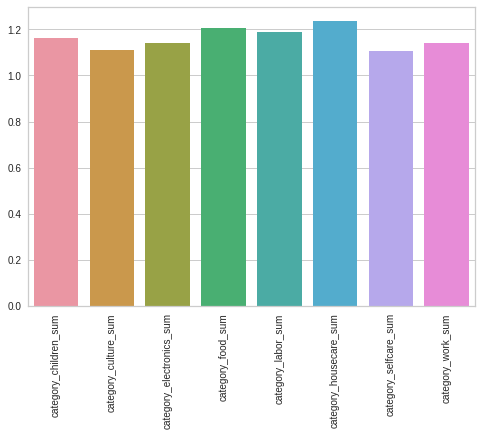

In [9]:
cats = ['category_children_sum','category_culture_sum','category_electronics_sum',
        'category_food_sum','category_labor_sum','category_housecare_sum',
        'category_selfcare_sum','category_work_sum']
freqs = [items[items[cat]>0][cat].describe()["mean"] for cat in cats]
ax = sns.barplot(y=freqs, x=cats)
for item in ax.get_xticklabels():
        item.set_rotation(90)
plt.show()

In [10]:
# cleaning
del app_customers, app_orders, app_reviews, app_pay, app_products, app_translate, app_items, orders, reviews, payments, items, cid_to_ucid, oid_to_cuid
gc.collect()

35

### Traitement des valeurs manquantes

In [11]:
for col in app.columns.tolist():
    print(f"{col}: {app[col].isnull().sum()}")

orders_count: 0
geolocation_lat: 0
geolocation_lng: 0
recency_min: 0
shipping_delay_mean: 0
payment_delay_mean: 0
delivery_estimation_error_mean: 0
review_score_min: 0
review_score_max: 0
review_score_mean: 0
review_score_count: 0
customer_left_message_mean: 0
review_delay_mean: 0
payment_type_credit_card_max: 1
payment_type_boleto_max: 1
payment_type_debit_card_max: 1
payment_type_voucher_max: 1
payment_installments_sum: 1
payment_installments_mean: 1
payment_value_sum: 1
payment_value_mean: 1
product_description_lenght_mean: 1254
product_photos_qty_mean: 1254
product_weight_g_mean: 13
product_volume_m3_mean: 13
category_score_mean: 0
category_children_max: 0
category_children_sum: 0
category_culture_max: 0
category_culture_sum: 0
category_electronics_max: 0
category_electronics_sum: 0
category_food_max: 0
category_food_sum: 0
category_labor_max: 0
category_labor_sum: 0
category_housecare_max: 0
category_housecare_sum: 0
category_selfcare_max: 0
category_selfcare_sum: 0
category_work_

In [12]:
try:
    app = app.drop(['830d5b7aaa3b6f1e9ad63703bec97d23']) # delete only wrong payment row (usercase abuse)
except:
    pass

Les seules autres valeurs manquantes sont dans les colonnes contenant des statistiques relatives à la description des produits. 

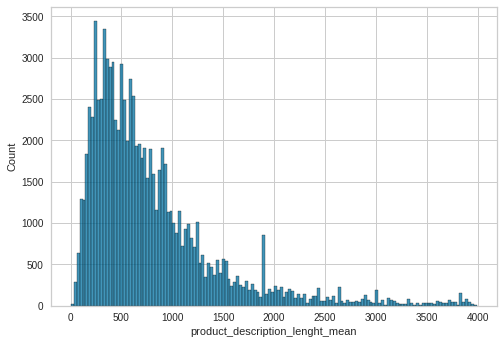

In [13]:
sns.histplot(data=app, x="product_description_lenght_mean")
plt.show()

Il n'existe quasiment aucune description vide donc les NaN sont probablement les descriptions manquantes. On impute ces valeurs par 0.

In [14]:
app = app.fillna(0)
for col in app.columns.tolist():
    print(f"{col}: {app[col].isnull().sum()}")

orders_count: 0
geolocation_lat: 0
geolocation_lng: 0
recency_min: 0
shipping_delay_mean: 0
payment_delay_mean: 0
delivery_estimation_error_mean: 0
review_score_min: 0
review_score_max: 0
review_score_mean: 0
review_score_count: 0
customer_left_message_mean: 0
review_delay_mean: 0
payment_type_credit_card_max: 0
payment_type_boleto_max: 0
payment_type_debit_card_max: 0
payment_type_voucher_max: 0
payment_installments_sum: 0
payment_installments_mean: 0
payment_value_sum: 0
payment_value_mean: 0
product_description_lenght_mean: 0
product_photos_qty_mean: 0
product_weight_g_mean: 0
product_volume_m3_mean: 0
category_score_mean: 0
category_children_max: 0
category_children_sum: 0
category_culture_max: 0
category_culture_sum: 0
category_electronics_max: 0
category_electronics_sum: 0
category_food_max: 0
category_food_sum: 0
category_labor_max: 0
category_labor_sum: 0
category_housecare_max: 0
category_housecare_sum: 0
category_selfcare_max: 0
category_selfcare_sum: 0
category_work_max: 0
c

In [15]:
print(f"Taille du jeu de données final: {app.shape}\n")

Taille du jeu de données final: (93081, 42)



In [16]:
app.head()

,orders_count,geolocation_lat,geolocation_lng,recency_min,shipping_delay_mean,payment_delay_mean,delivery_estimation_error_mean,review_score_min,review_score_max,review_score_mean,review_score_count,customer_left_message_mean,review_delay_mean,payment_type_credit_card_max,payment_type_boleto_max,payment_type_debit_card_max,payment_type_voucher_max,payment_installments_sum,payment_installments_mean,payment_value_sum,payment_value_mean,product_description_lenght_mean,product_photos_qty_mean,product_weight_g_mean,product_volume_m3_mean,category_score_mean,category_children_max,category_children_sum,category_culture_max,category_culture_sum,category_electronics_max,category_electronics_sum,category_food_max,category_food_sum,category_labor_max,category_labor_sum,category_housecare_max,category_housecare_sum,category_selfcare_max,category_selfcare_sum,category_work_max,category_work_sum
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,-23.335331,-46.828647,111.169560,6.400914,14.850000,-4.132905,5,5,5.0,1,1.0,4.572778,1.0,0.0,0.0,0.0,8.0,8.0,141.90,141.90,236.0,1.0,1500.0,0.007616,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,-23.567395,-46.792957,114.159144,2.984005,434.283333,-4.248125,4,4,4.0,1,0.0,0.937095,1.0,0.0,0.0,0.0,1.0,1.0,27.19,27.19,635.0,1.0,375.0,0.005148,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
0000f46a3911fa3c0805444483337064,1,-27.543787,-48.625680,536.746921,25.731759,0.000000,-1.389734,3,3,3.0,1,0.0,1.055370,1.0,0.0,0.0,0.0,8.0,8.0,86.22,86.22,177.0,3.0,1500.0,0.043750,4.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,1,-1.311011,-48.482884,320.771481,20.023472,19.600000,-11.108970,4,4,4.0,1,1.0,1.012396,1.0,0.0,0.0,0.0,4.0,4.0,43.62,43.62,1741.0,5.0,150.0,0.001045,2.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,1,-23.504368,-47.466156,287.802025,13.126435,21.166667,-7.035463,5,5,5.0,1,0.0,4.937211,1.0,0.0,0.0,0.0,6.0,6.0,196.89,196.89,794.0,3.0,6050.0,0.000528,2.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


# Classification non supervisée

### Normalisation des données

In [17]:
def normalize(df):
    df['index'] = [i for i in range(df.shape[0])]
    df = df.set_index('index')
    short_app = df[['delivery_estimation_error_mean', 'review_score_mean', 'payment_value_mean', 'category_score_mean']]
    scaler = StandardScaler()
    scaler.fit(short_app)
    X_scale = scaler.transform(short_app)
    app_sca = pd.DataFrame(X_scale, columns=short_app.columns)
    
    return app_sca

In [18]:
app_scale = normalize(app)
app_scale.head()

,delivery_estimation_error_mean,review_score_mean,payment_value_mean,category_score_mean
0,0.692578,0.665762,-0.072623,-0.637646
1,0.681212,-0.108466,-0.601376,-1.176151
2,0.963160,-0.882694,-0.329279,0.977868
3,0.004468,-0.108466,-0.525642,-0.099141
4,0.406273,0.665762,0.180851,-0.099141


### Clustering hierarchique

In [19]:
app_scale = app_scale.sample(frac=data_frac)

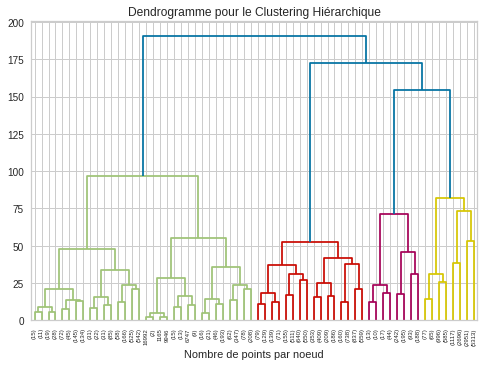

19169

In [20]:
app_dendro = app_scale.sample(frac=dendro_data_frac)
dendrogram_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(app_dendro)
plt.title('Dendrogramme pour le Clustering Hiérarchique')
counts = np.zeros(dendrogram_model.children_.shape[0])
n_samples = len(dendrogram_model.labels_)
for i, merge in enumerate(dendrogram_model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([dendrogram_model.children_, dendrogram_model.distances_,
                                  counts]).astype(float)
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.xlabel("Nombre de points par noeud")
plt.show()
del dendrogram_model
gc.collect()

In [21]:
agglo_n_clust = 6
agglo = AgglomerativeClustering(n_clusters=agglo_n_clust).fit(app_scale)

### Clustering par densité (DBSCAN)

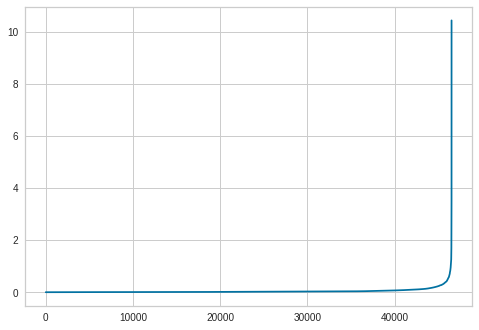

In [22]:
# finding epsilon using nearest neighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(app_scale)
distances, indices = nbrs.kneighbors(app_scale)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [23]:
dbscan = DBSCAN(eps=0.75, min_samples=5).fit(app_scale)
db_n_clust = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

### Kmeans

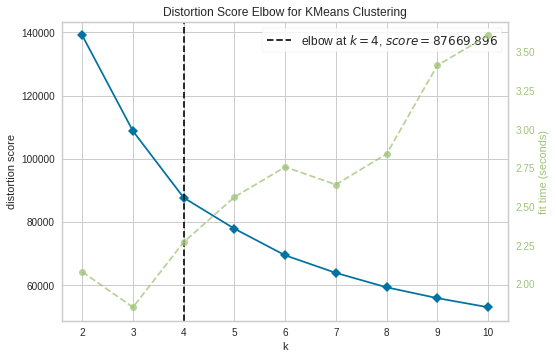

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
kmeans_elbow = KElbowVisualizer(KMeans(), k=10, metric="distortion")
kmeans_elbow.fit(app_scale)
kmeans_elbow.show()

In [25]:
kmeans = KMeans(n_clusters = kmeans_elbow.elbow_value_).fit(app_scale)

# Résultats

In [26]:
models = [("K-means", kmeans, kmeans_elbow.elbow_value_),
          ("Hierarchical Clustering", agglo, agglo_n_clust),
          ("DBSCAN", dbscan, db_n_clust)]

### Silhouette score

In [27]:
for model_name, model, _ in models:
    print(f"Silhouette score for {model_name}: {silhouette_score(app_scale, model.labels_, metric='euclidean')}")

Silhouette score for K-means: 0.3530618287875921
Silhouette score for Hierarchical Clustering: 0.2645573634036821
Silhouette score for DBSCAN: 0.2885585834982137


### Visualisation avec réduction par ACP

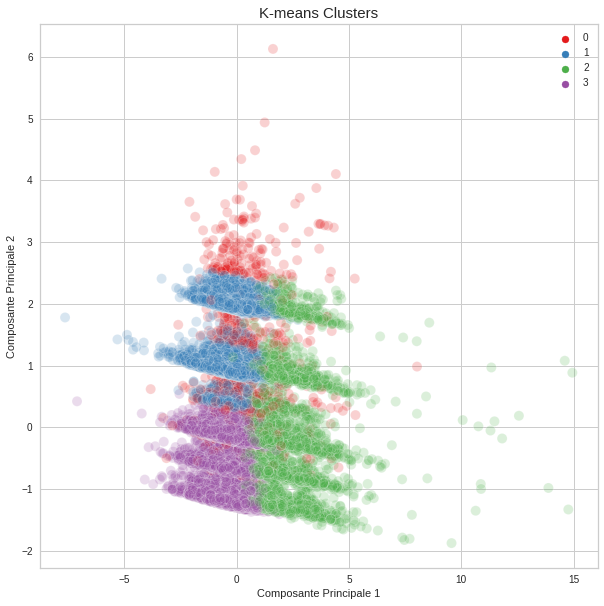

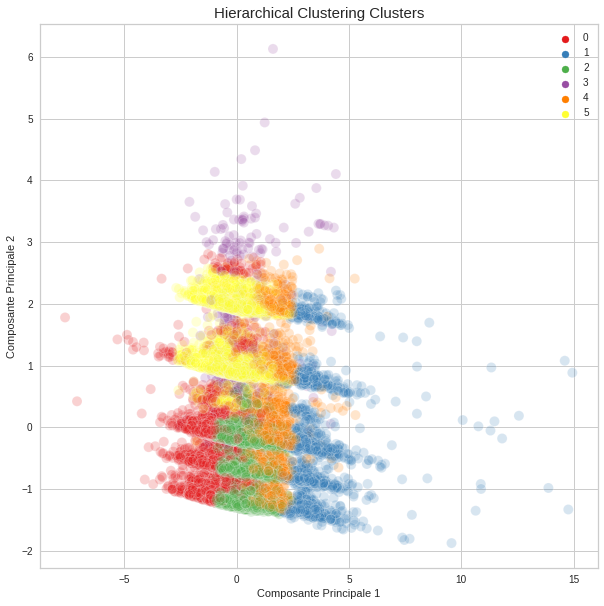

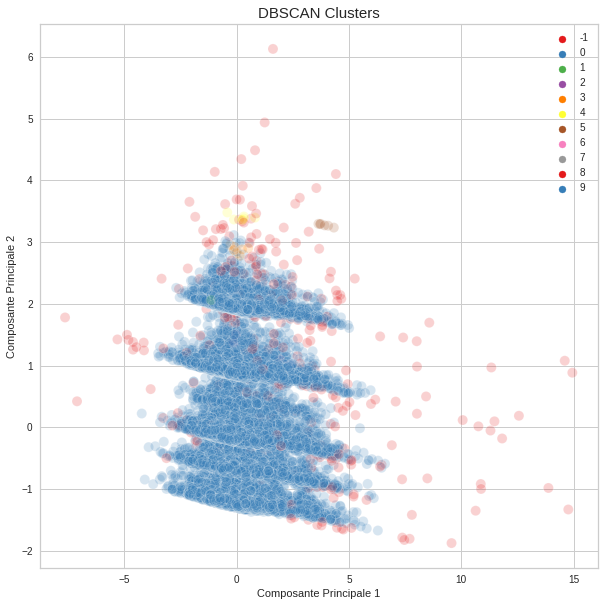

In [28]:
pca = PCA(n_components=2).fit(app_scale)
pca2d = pca.transform(app_scale)
for model_name, model, _ in models:
    plt.figure(figsize = (10,10))
    sns.scatterplot(pca2d[:,0], pca2d[:,1], hue=model.labels_, palette='Set1',
                s=100, alpha=0.2).set_title(f'{model_name} Clusters', fontsize=15)
    plt.legend()
    plt.ylabel('Composante Principale 2')
    plt.xlabel('Composante Principale 1')
    plt.show()

In [29]:
def display_graphs(mdls, app_sca):
    for model_name, model, nclust in mdls:
        if model_name == "K-means":
            centroids = pd.DataFrame(model.cluster_centers_, columns=app_sca.columns)
            centroids['cluster'] = centroids.index
        else:
            app_sca["cluster"] = model.labels_
            centroids = app_sca.groupby(by="cluster").mean().reset_index()
        display_parallel_coordinates_centroids(centroids, nclust, model_name)

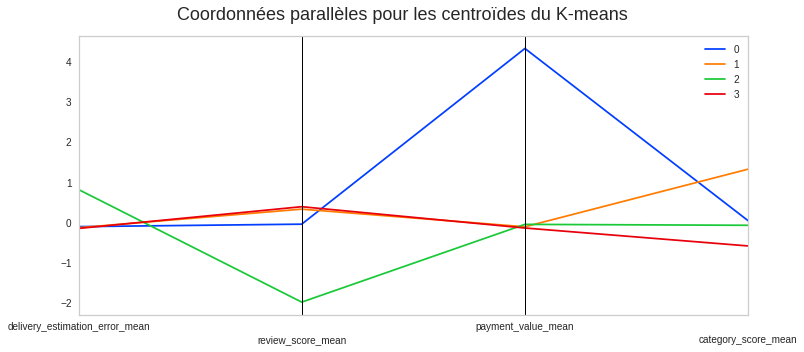

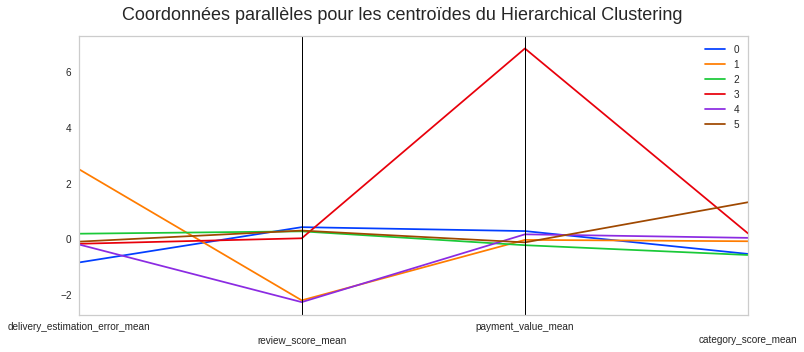

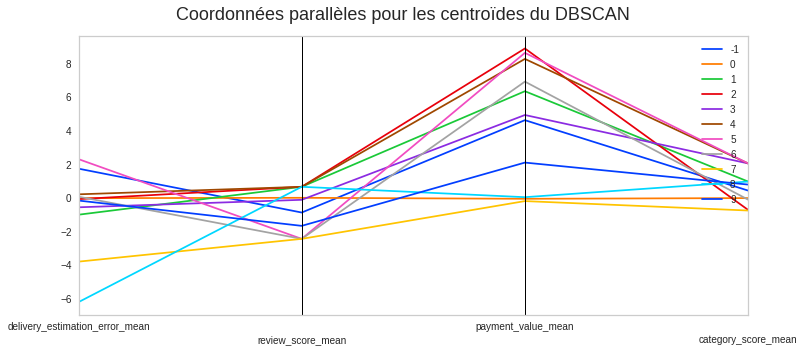

In [30]:
display_graphs(models, app_scale)

# Analyse de la stabilité

Etude de la distribution des dates d'achat

In [31]:
app.head()

,orders_count,geolocation_lat,geolocation_lng,recency_min,shipping_delay_mean,payment_delay_mean,delivery_estimation_error_mean,review_score_min,review_score_max,review_score_mean,review_score_count,customer_left_message_mean,review_delay_mean,payment_type_credit_card_max,payment_type_boleto_max,payment_type_debit_card_max,payment_type_voucher_max,payment_installments_sum,payment_installments_mean,payment_value_sum,payment_value_mean,product_description_lenght_mean,product_photos_qty_mean,product_weight_g_mean,product_volume_m3_mean,category_score_mean,category_children_max,category_children_sum,category_culture_max,category_culture_sum,category_electronics_max,category_electronics_sum,category_food_max,category_food_sum,category_labor_max,category_labor_sum,category_housecare_max,category_housecare_sum,category_selfcare_max,category_selfcare_sum,category_work_max,category_work_sum,index
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,-23.335331,-46.828647,111.169560,6.400914,14.850000,-4.132905,5,5,5.0,1,1.0,4.572778,1.0,0.0,0.0,0.0,8.0,8.0,141.90,141.90,236.0,1.0,1500.0,0.007616,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,-23.567395,-46.792957,114.159144,2.984005,434.283333,-4.248125,4,4,4.0,1,0.0,0.937095,1.0,0.0,0.0,0.0,1.0,1.0,27.19,27.19,635.0,1.0,375.0,0.005148,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
0000f46a3911fa3c0805444483337064,1,-27.543787,-48.625680,536.746921,25.731759,0.000000,-1.389734,3,3,3.0,1,0.0,1.055370,1.0,0.0,0.0,0.0,8.0,8.0,86.22,86.22,177.0,3.0,1500.0,0.043750,4.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2
0000f6ccb0745a6a4b88665a16c9f078,1,-1.311011,-48.482884,320.771481,20.023472,19.600000,-11.108970,4,4,4.0,1,1.0,1.012396,1.0,0.0,0.0,0.0,4.0,4.0,43.62,43.62,1741.0,5.0,150.0,0.001045,2.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,3
0004aac84e0df4da2b147fca70cf8255,1,-23.504368,-47.466156,287.802025,13.126435,21.166667,-7.035463,5,5,5.0,1,0.0,4.937211,1.0,0.0,0.0,0.0,6.0,6.0,196.89,196.89,794.0,3.0,6050.0,0.000528,2.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,4


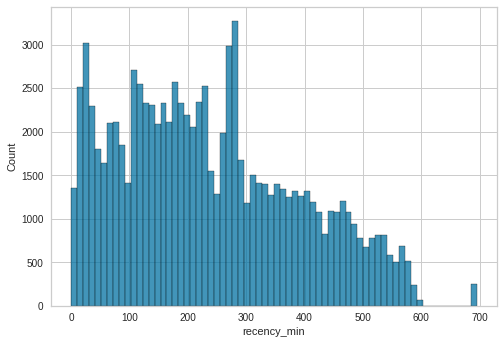

In [32]:
sns.histplot(data=app, x="recency_min")
plt.show()

### Séparation temporelle des données

In [33]:
split_app = app.copy()
split1 = split_app[split_app["recency_min"]<=170].sample(frac=data_frac_2)
split2 = split_app[(split_app["recency_min"]>170) & (split_app["recency_min"]<=350)].sample(frac=data_frac_2)
split3 = split_app[(split_app["recency_min"]>350) & (split_app["recency_min"]<=600)].sample(frac=data_frac_2)

def run_models(spl):
    normalized = normalize(spl)
    km = KMeans(n_clusters=kmeans_elbow.elbow_value_).fit(normalized)
    ag = AgglomerativeClustering(n_clusters=agglo_n_clust).fit(normalized)
    db = DBSCAN(eps=0.75, min_samples=5).fit(normalized)
    dbs_n_clust = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    mmodels = [("K-means", km, kmeans_elbow.elbow_value_),
              ("Hierarchical Clustering", ag, agglo_n_clust),
              ("DBSCAN", db, dbs_n_clust)]
    for model_name, model, _ in mmodels:
        app_labeled = pd.concat([app, pd.DataFrame({'cluster':model.labels_})], axis=1)
        print(f"Silhouette score for {model_name}: {silhouette_score(normalized, model.labels_, metric='euclidean')}")
        print("Répartition des clusters:")
        sns.histplot(data=app_labeled, x="cluster")
        plt.show()
    display_graphs(mmodels, normalized)

Silhouette score for K-means: 0.3382218013072564
Répartition des clusters:


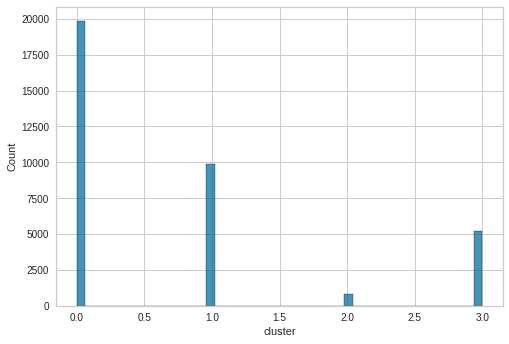

Silhouette score for Hierarchical Clustering: 0.2410069418902802
Répartition des clusters:


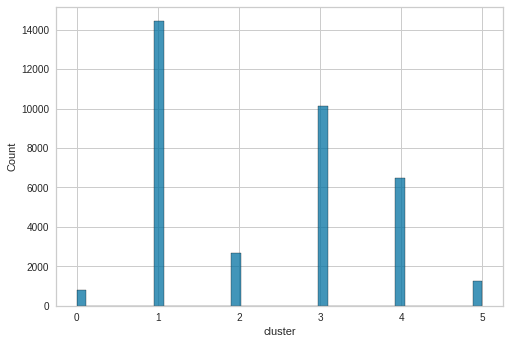

Silhouette score for DBSCAN: 0.4644707790811053
Répartition des clusters:


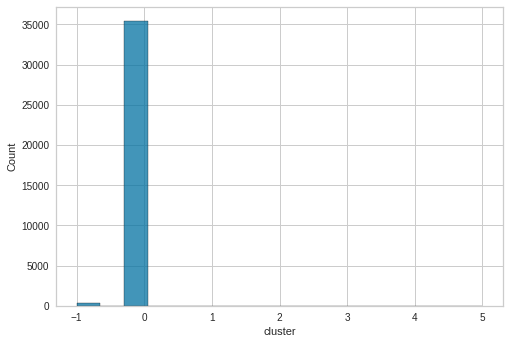

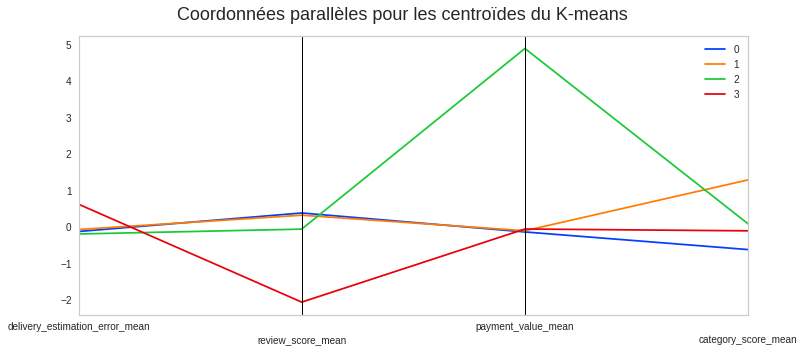

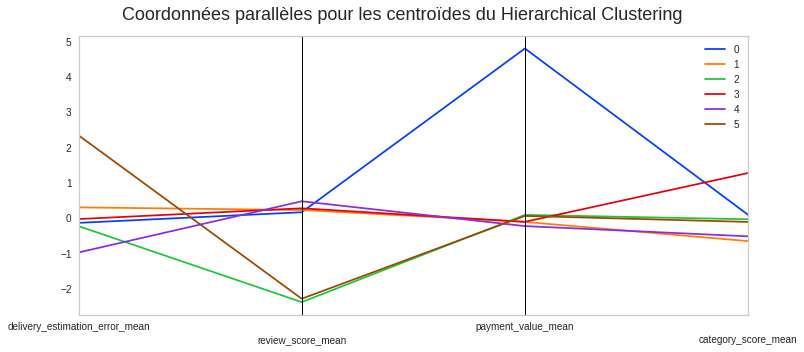

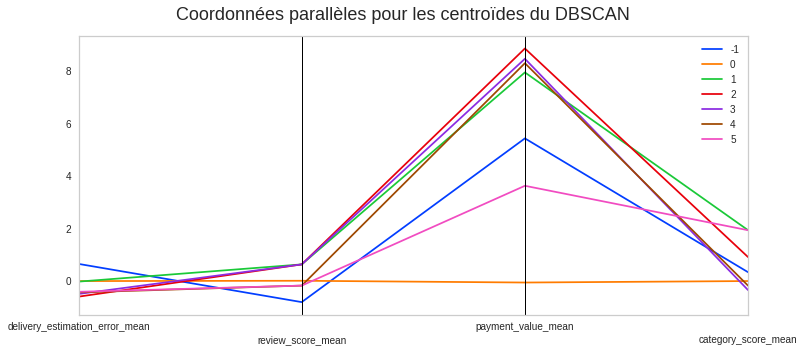

In [34]:
run_models(split1)

Deuxième période:

Silhouette score for K-means: 0.3611057250777841
Répartition des clusters:


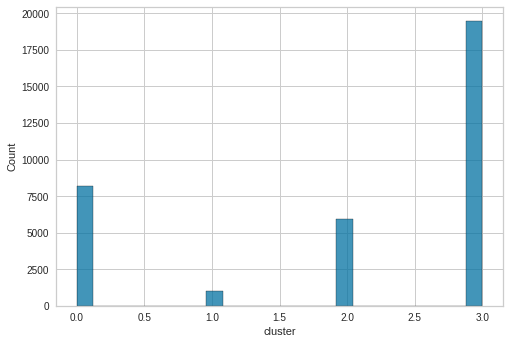

Silhouette score for Hierarchical Clustering: 0.3269946599656005
Répartition des clusters:


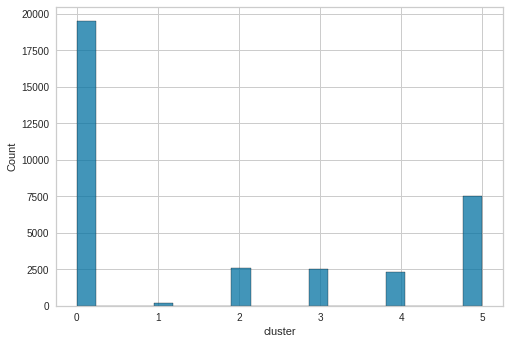

Silhouette score for DBSCAN: 0.636366524477894
Répartition des clusters:


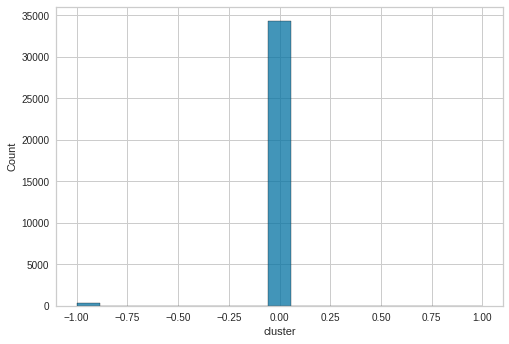

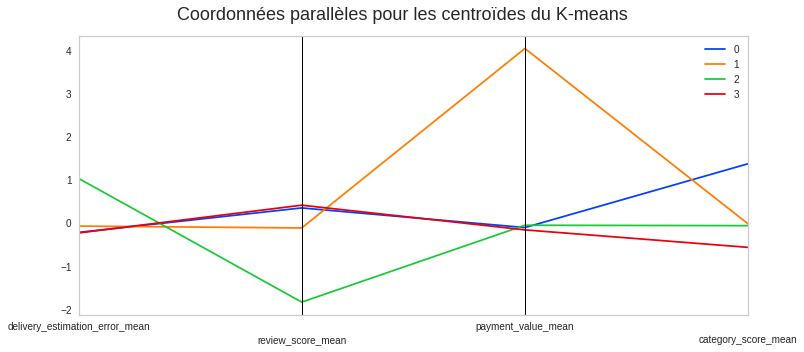

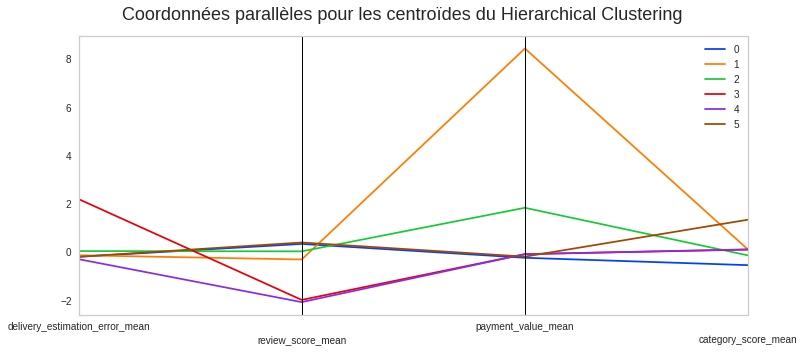

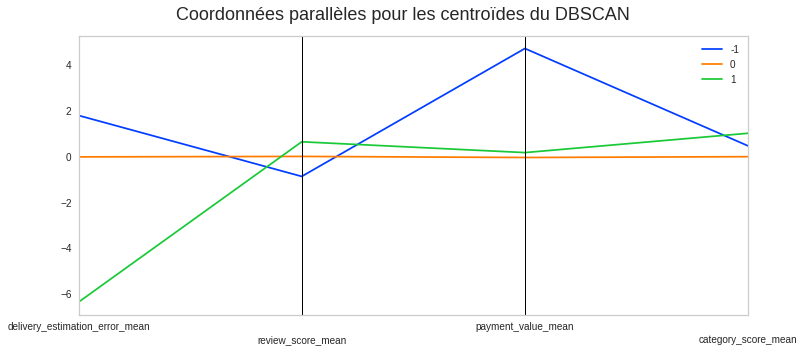

In [35]:
run_models(split2)

Troisième période:

Silhouette score for K-means: 0.3545900111270509
Répartition des clusters:


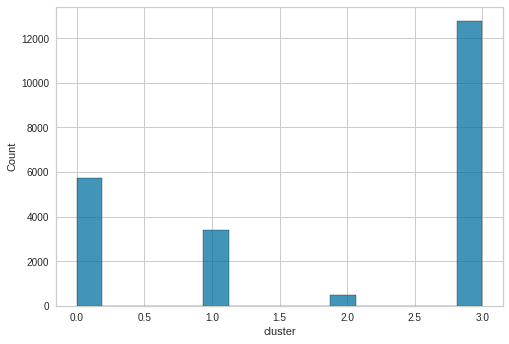

Silhouette score for Hierarchical Clustering: 0.2597006059373326
Répartition des clusters:


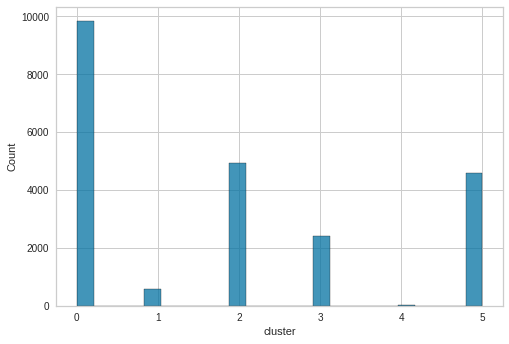

Silhouette score for DBSCAN: 0.2406632637905266
Répartition des clusters:


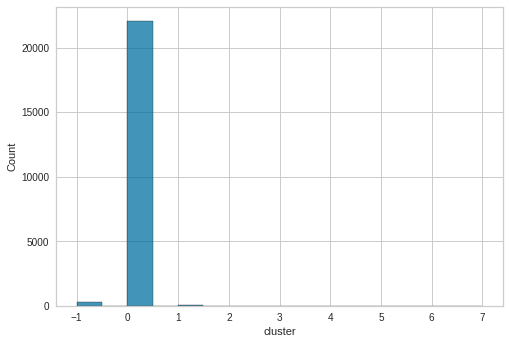

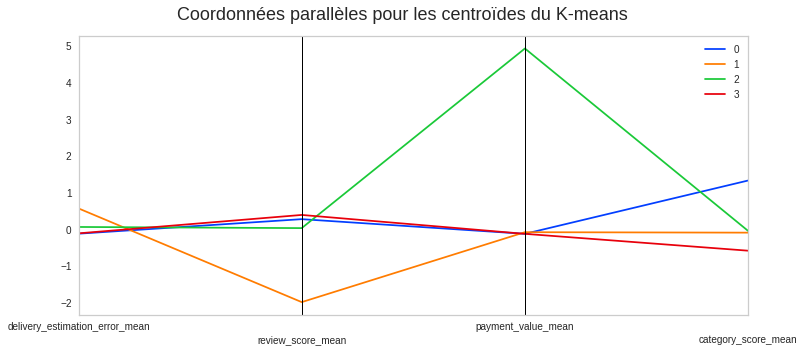

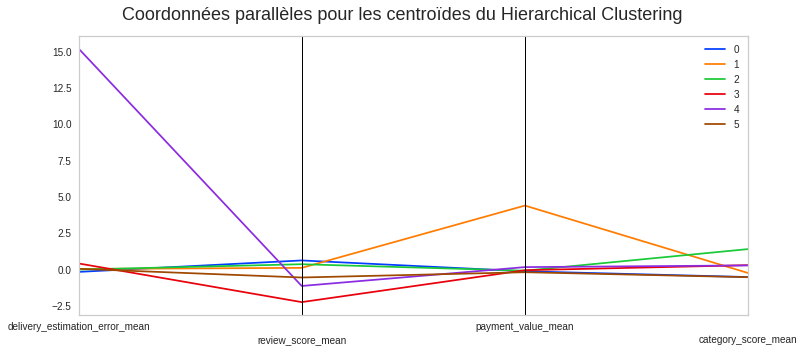

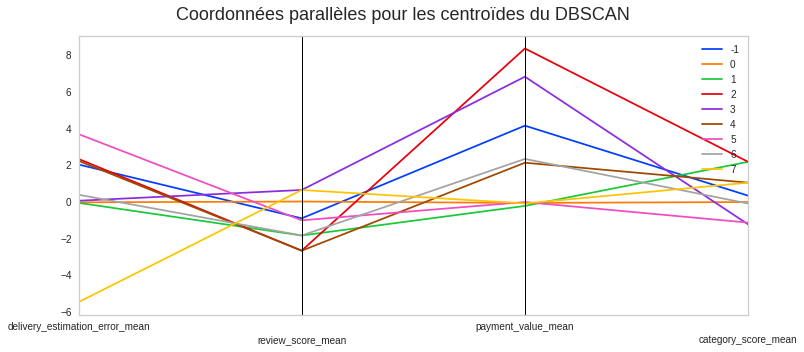

In [36]:
run_models(split3)